In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
%matplotlib inline

In [3]:
target_types={6:'Microlensing', 15:'Explosive Type V', 16:'Transits', 42:'Explosive type W', 52:'Explosive Type X', 
                  53:'Long periodic', 62:'Explosive Type Y', 64:'Near Burst', 65:'Flare', 67:'Explosive Type Z',
                  88:'AGN', 90:'SN Type U', 92:'Periodic', 95:'SN Type T'}

In [4]:
train_series = pd.read_csv('../input/training_set.csv')
train_metadata = pd.read_csv('../input/training_set_metadata.csv')

In [5]:
groups = train_series.groupby(['object_id', 'passband'])
times = groups.apply(
    lambda block: block['mjd'].values).reset_index().rename(columns={0: 'seq'})
flux = groups.apply(
    lambda block: block['flux'].values
).reset_index().rename(columns={0: 'seq'})
err = groups.apply(
    lambda block: block['flux_err'].values
).reset_index().rename(columns={0: 'seq'})
det = groups.apply(
    lambda block: block['detected'].astype(bool).values
).reset_index().rename(columns={0: 'seq'})
times_list = times.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
flux_list = flux.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
err_list = err.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
det_list = det.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()

In [6]:
object_list=times.groupby('object_id').apply(lambda x: x['object_id'].unique()[0]).tolist()

In [7]:
for t in sorted(train_metadata['target'].unique()):
    print t,train_metadata[train_metadata['target']== t]['target'].count(),target_types[t],train_metadata[train_metadata['target']== t]['hostgal_specz'].mean()

6 151 Microlensing 0.0
15 495 Explosive Type V 0.243576767677
16 924 Transits 0.0
42 1193 Explosive type W 0.229962447611
52 183 Explosive Type X 0.229706010929
53 30 Long periodic 0.0
62 484 Explosive Type Y 0.194970454545
64 102 Near Burst 0.0743980392157
65 981 Flare 0.0
67 208 Explosive Type Z 0.225448557692
88 370 AGN 0.967997027027
90 2313 SN Type U 0.363081279723
92 239 Periodic 0.0
95 175 SN Type T 1.21743828571


In [8]:
colors = ['purple', 'blue', 'green', 'orange', 'red', 'black']
def plot_one_object(obj_id,split=False,frequency=0):
    
    if split:
        fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
    else:
        ax=plt.gca()
    for band in range(len(colors)):
        if split:
            ax = axes[band // 3, band % 3]
        sample = train_series[(train_series['object_id'] == obj_id) & (train_series['passband']==band)]
        if frequency:
            phase=(sample['mjd'] * frequency ) % 1
        else:
            phase=sample['mjd']
        ax.errorbar(x=phase,y=sample['flux'],yerr=sample['flux_err'],c = colors[band],fmt='o',alpha=0.7)
        

In [9]:
gal_target=train_metadata[train_metadata['hostgal_photoz']==0.0]['target'].unique()
t_type={}
ddf_type={}
wdf_type={}
for t in gal_target:
    t_type[t] = train_metadata[(train_metadata['target']==t)].index
    ddf_type[t] = train_metadata[(train_metadata['target']==t) & (train_metadata['ddf']==1)].index
    wdf_type[t] = train_metadata[(train_metadata['target']==t) & (train_metadata['ddf']==0)].index
t_colors={6:'blue',16:'red',65:'orange',92:'green',53:'purple'}


In [10]:
from astropy.stats import LombScargle

In [11]:
def plot_period(iobj):
    time_obj = np.concatenate(times_list[iobj])
    flux_obj = np.concatenate(flux_list[iobj])
    err_obj = np.concatenate(err_list[iobj])

    frequency, power = LombScargle(time_obj, flux_obj,err_obj).autopower(maximum_frequency=16.0)
    #frequency, power = LombScargle(times_list[iobj][1], flux_list[iobj][1],err_list[iobj][1]).autopower()
    best_frequency=frequency[np.where(power==np.max(power))]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    ax=axes[0]
    ax.plot(frequency, power)
    ax=axes[1]
    plt.sca(ax)
    plot_one_object(object_list[iobj])
    ax.set_title(target_types[train_metadata.loc[iobj,'target']])
    ax=axes[2]
    plt.sca(ax)
    plot_one_object(object_list[iobj],frequency=best_frequency)
    return best_frequency

## Class 65 (Flare) metrics 

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


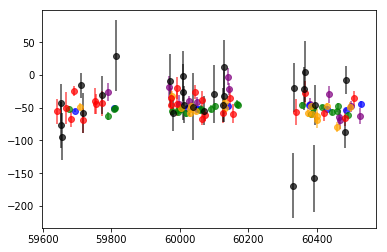

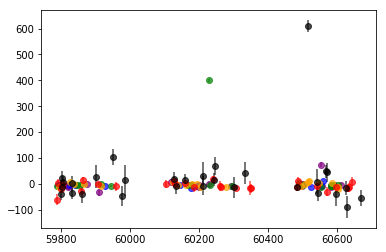

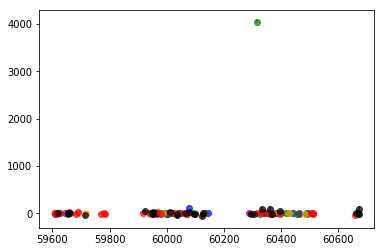

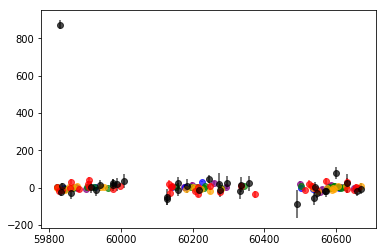

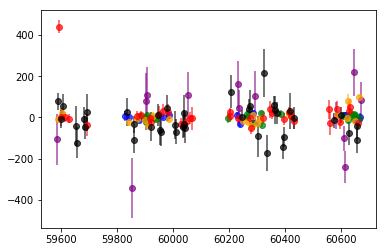

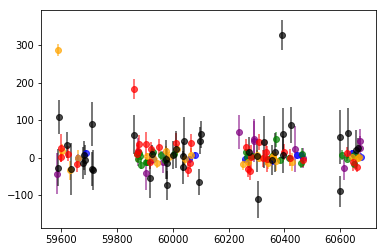

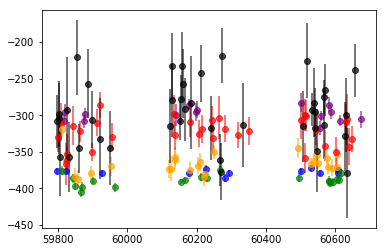

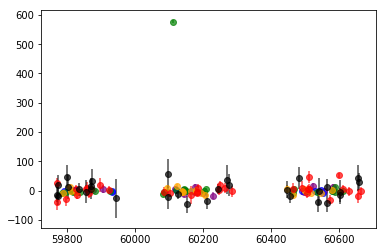

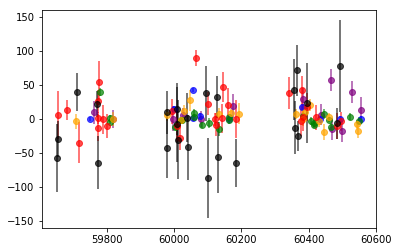

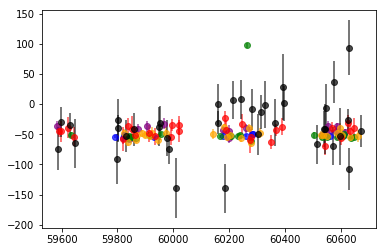

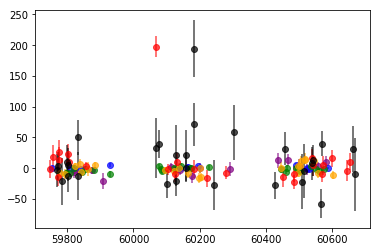

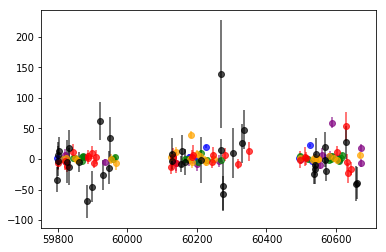

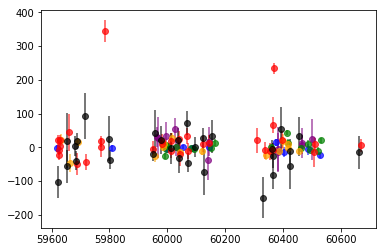

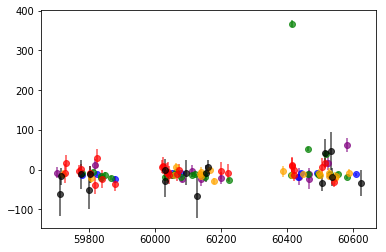

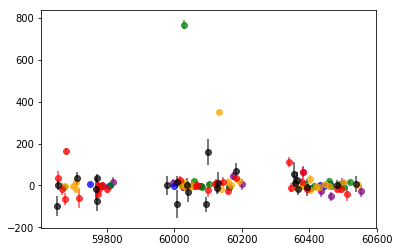

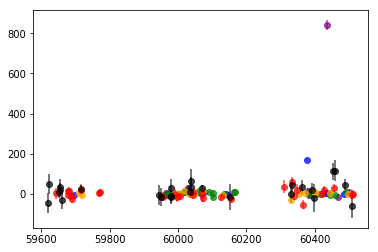

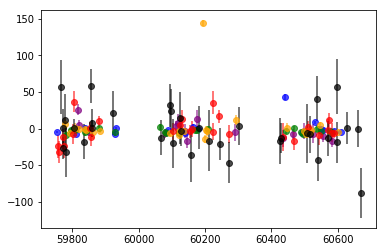

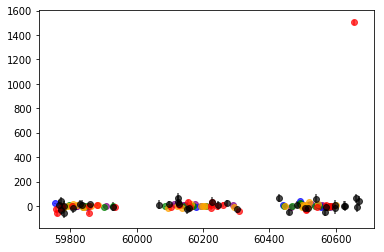

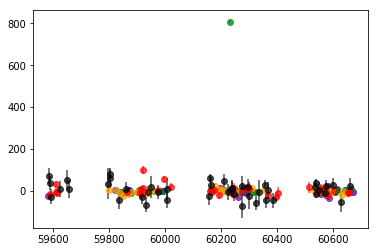

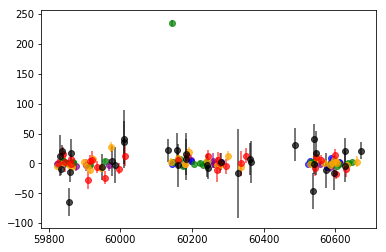

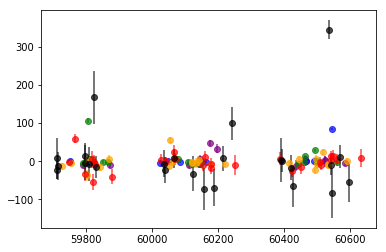

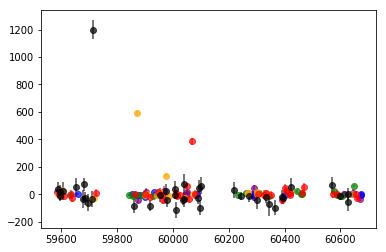

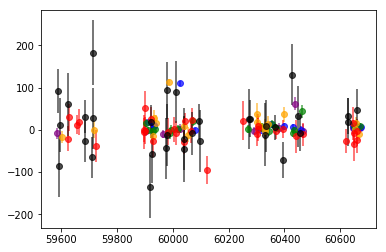

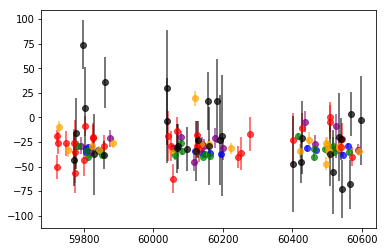

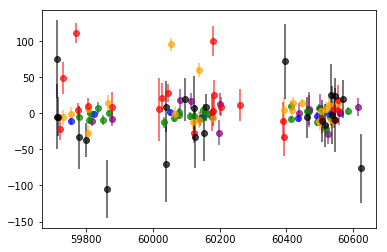

In [12]:
for iobj in train_metadata[(train_metadata['target']==65) & (train_metadata['ddf']==0)]['object_id'][:25]:
    plt.figure()
    plot_one_object(iobj)

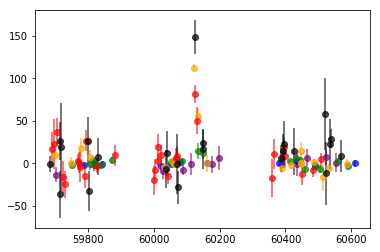

In [13]:
plot_one_object(20222858)
#plt.xlim(59900,60100)

### metrics :


In [14]:
def make_metrics_65():
    maxsigma_list = np.zeros(len(train_metadata))
    frac3sigma_list= np.zeros(len(train_metadata))
    for i in train_metadata[(train_metadata['hostgal_photoz']==0.0)].index:
        #print i
        maxsigma=np.zeros(6)
        nb3sigma=0
        nbdata=0
        for b in range(6):
            maxsigma[b] = np.max( (flux_list[i][b]-np.median(flux_list[i][b]))/ err_list[i][b] )
            nb3sigma += np.sum( ((flux_list[i][b]-np.median(flux_list[i][b]))/ err_list[i][b] )>3)
            nbdata += len(flux_list[i][b])
        maxsigma_list[i] = np.max(maxsigma)
        frac3sigma_list[i] = nb3sigma*1./(nbdata)
    return maxsigma_list, frac3sigma_list

In [15]:
# In fact : 3 sigma performs better !
maxsigma,frac3sigma = make_metrics_65()

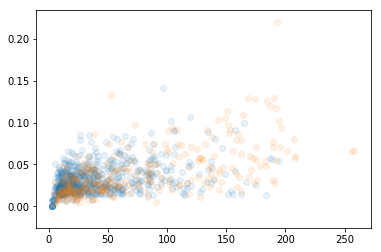

In [16]:
# ddf and wdf have different charactertistics !
plt.scatter(np.array([np.max(maxsig) for maxsig in maxsigma])[wdf_type[65]],np.array(frac3sigma)[wdf_type[65]],alpha=0.1)
plt.scatter(np.array([np.max(maxsig) for maxsig in maxsigma])[ddf_type[65]],np.array(frac3sigma)[ddf_type[65]],alpha=0.1)

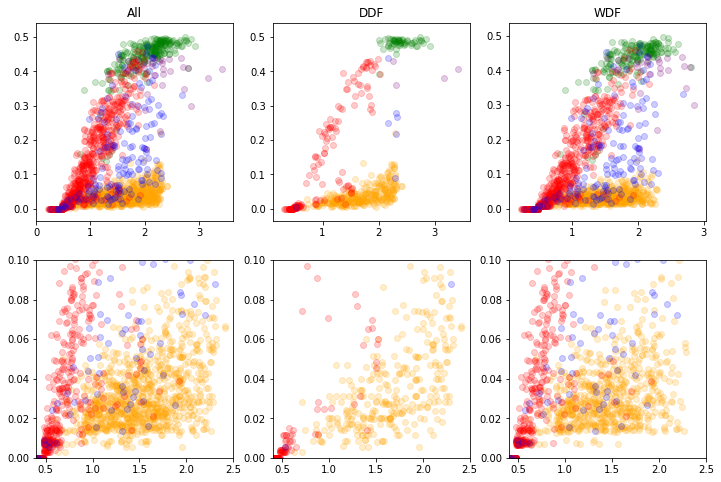

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for t in gal_target:
    ax = axes[0,0]
    ax.scatter(np.log10(maxsigma[t_type[t]]),frac3sigma[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,1]
    ax.scatter(np.log10(maxsigma[ddf_type[t]]),frac3sigma[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,2]
    ax.scatter(np.log10(maxsigma[wdf_type[t]]),frac3sigma[wdf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,0]
    ax.scatter(np.log10(maxsigma[t_type[t]]),frac3sigma[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,1]
    ax.scatter(np.log10(maxsigma[ddf_type[t]]),frac3sigma[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,2]
    ax.scatter(np.log10(maxsigma[wdf_type[t]]),frac3sigma[wdf_type[t]],color=t_colors[t],alpha=0.2)

ax = axes[0,0]
ax.set_title("All")
ax = axes[0,1]
ax.set_title("DDF")
ax = axes[0,2]
ax.set_title("WDF")
for i in range(3):
    ax = axes[1,i]
    ax.set_xlim((0.4,2.5))
    ax.set_ylim((0.0,0.1))

## Class 16 (Transits) metrics 

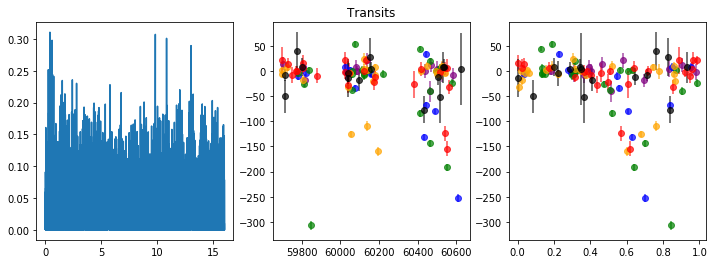

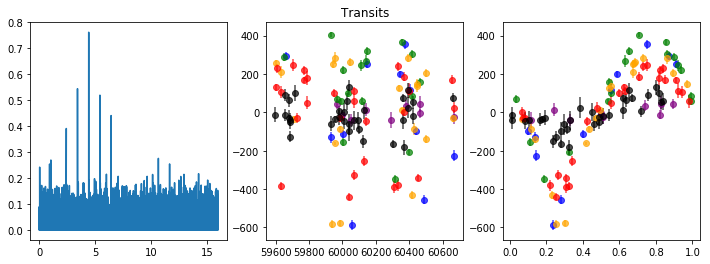

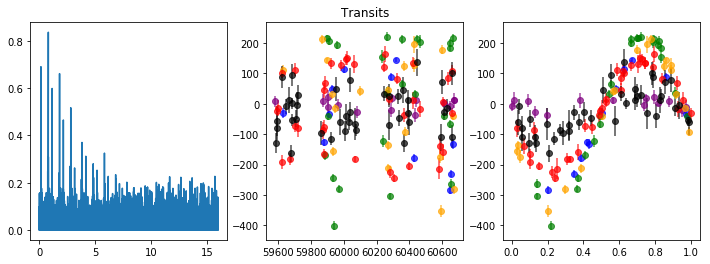

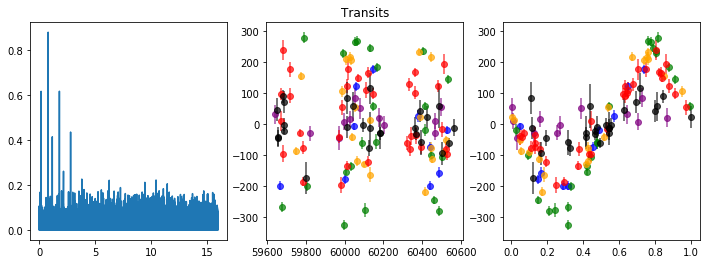

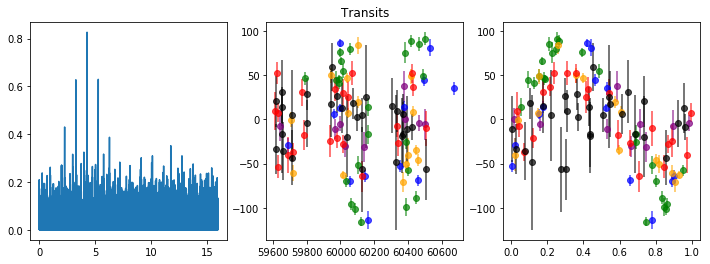

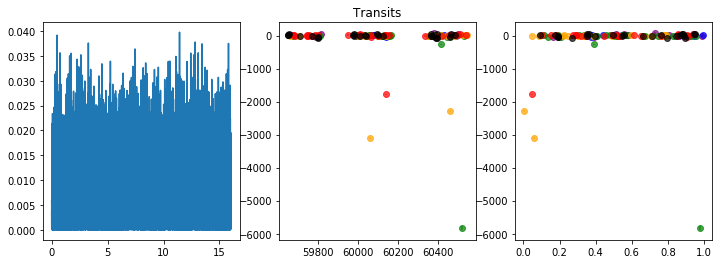

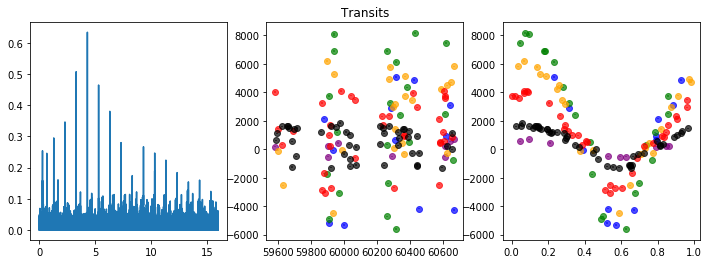

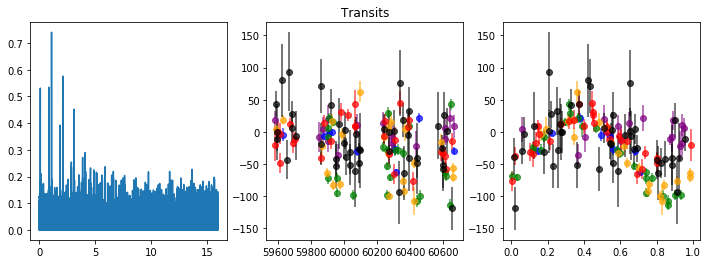

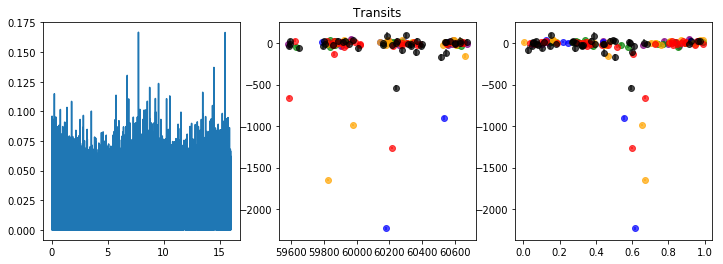

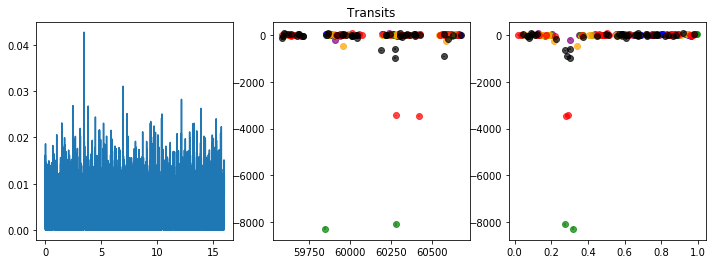

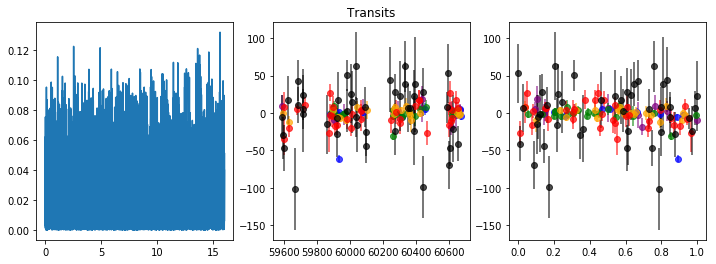

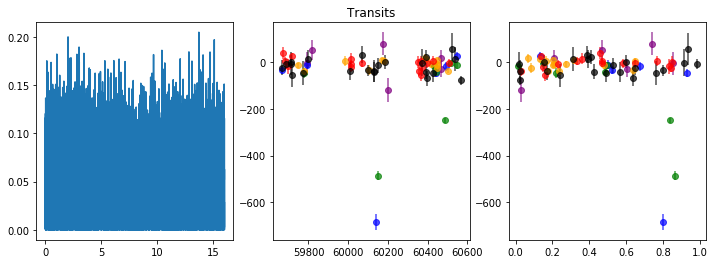

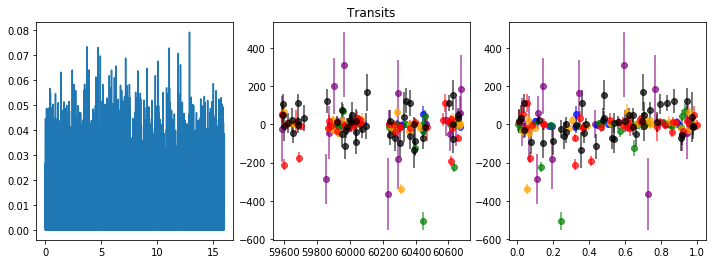

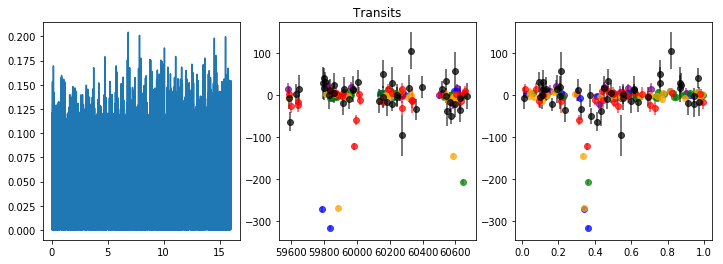

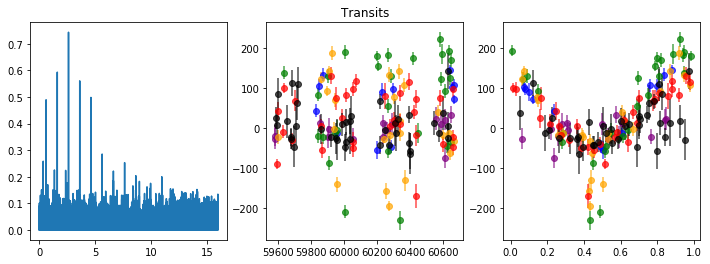

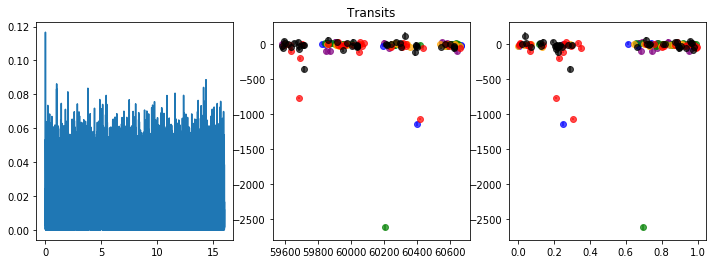

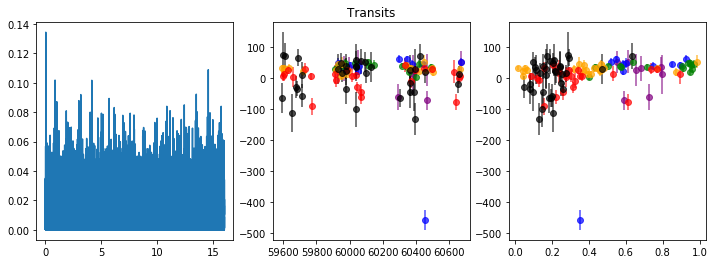

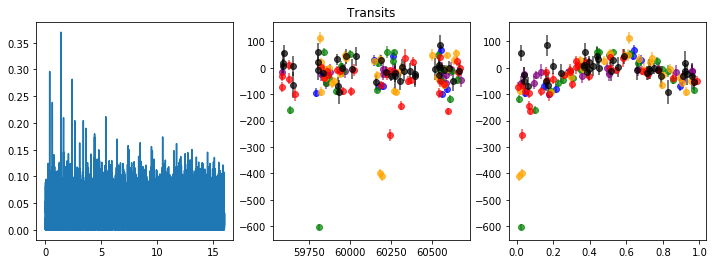

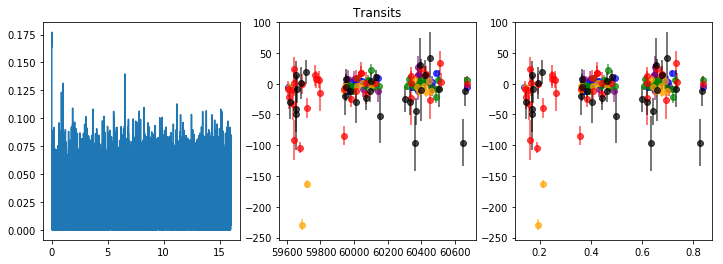

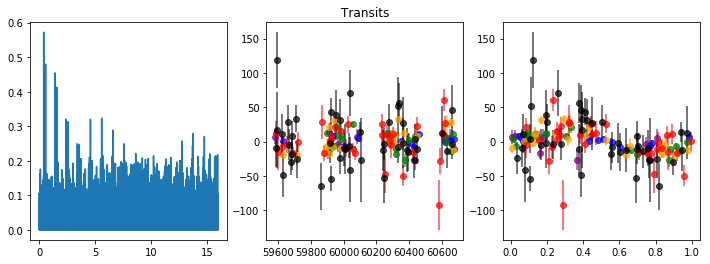

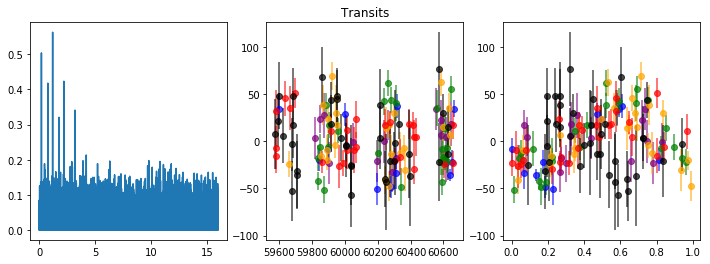

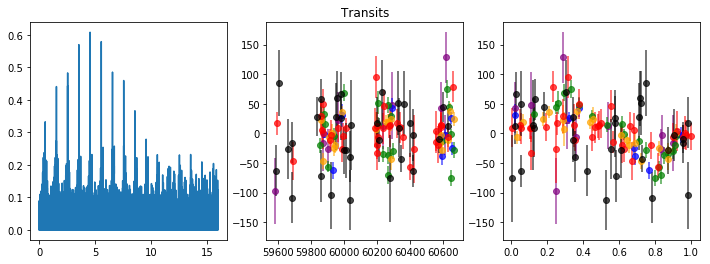

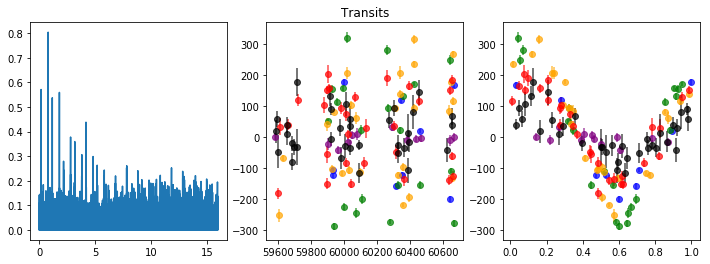

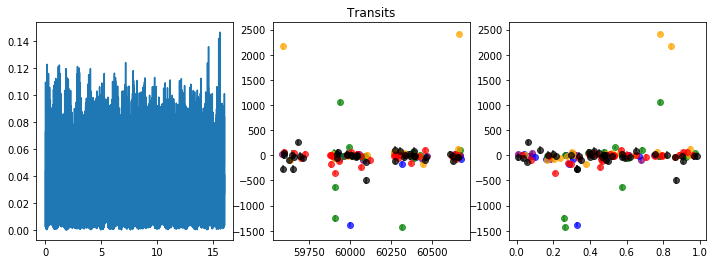

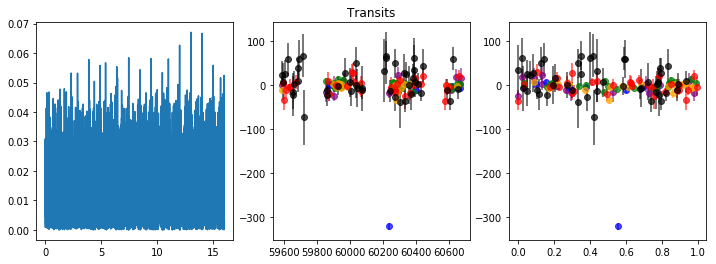

In [18]:
for iobj in train_metadata[(train_metadata['target']==16) & (train_metadata['ddf']==0)].index[:25]:
    plot_period(iobj)

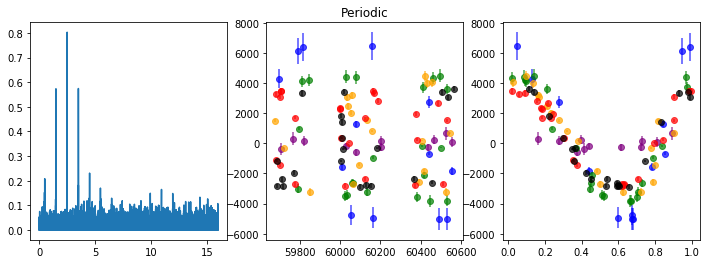

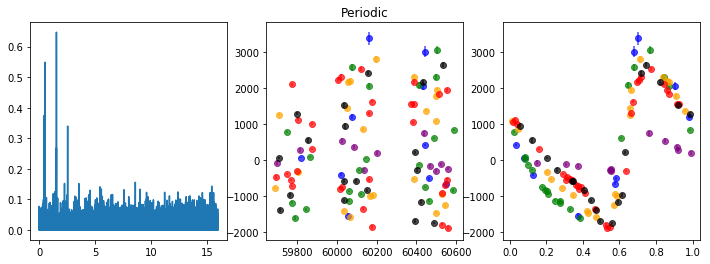

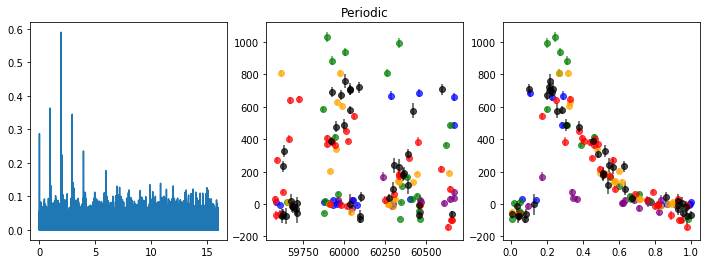

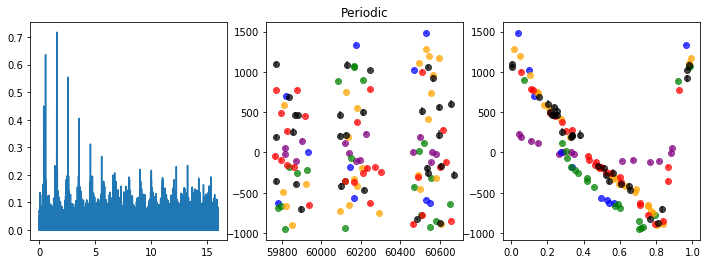

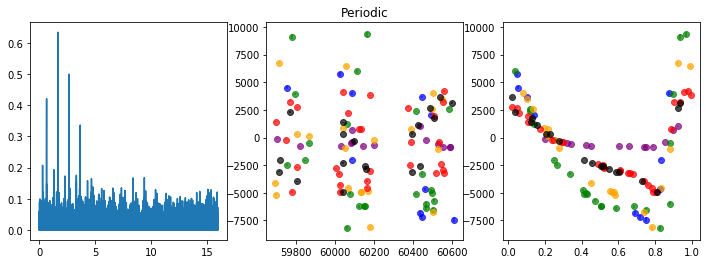

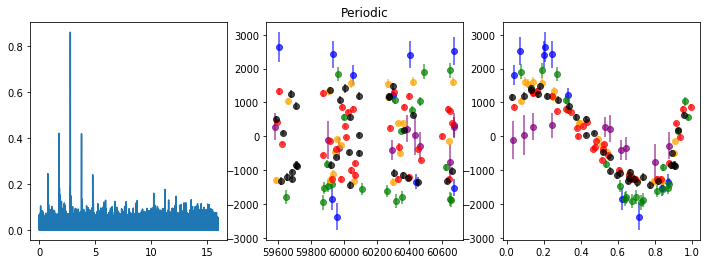

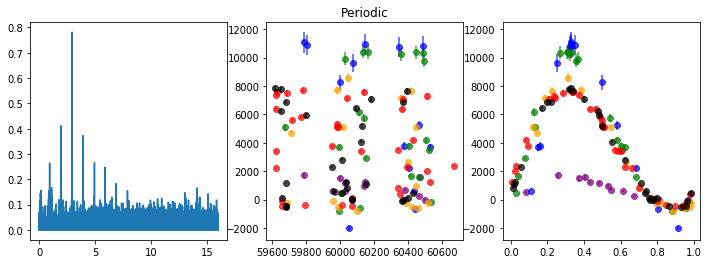

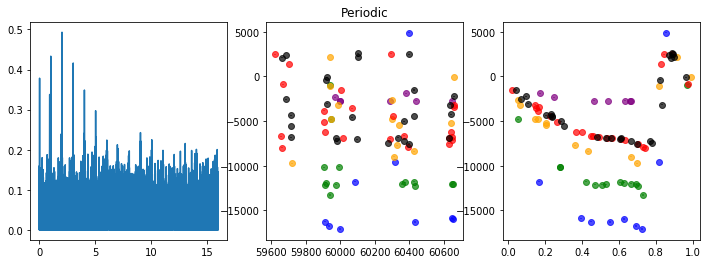

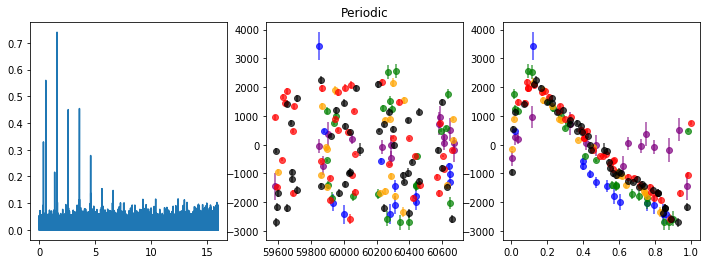

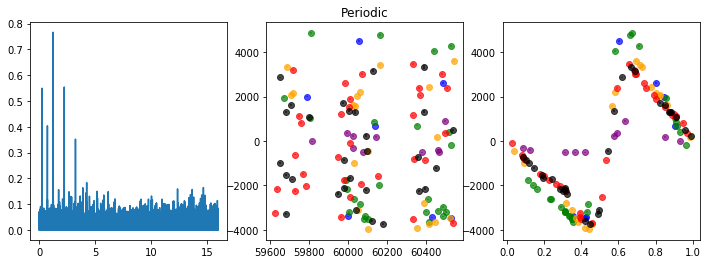

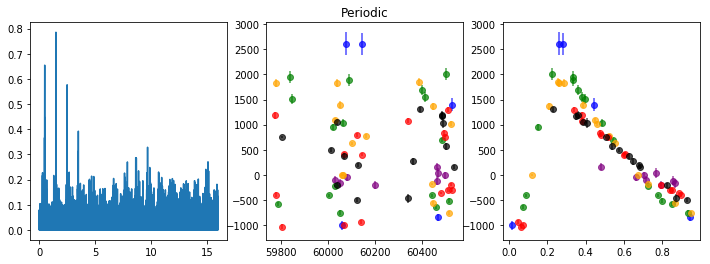

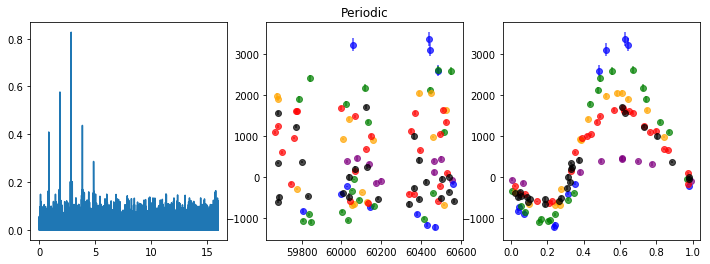

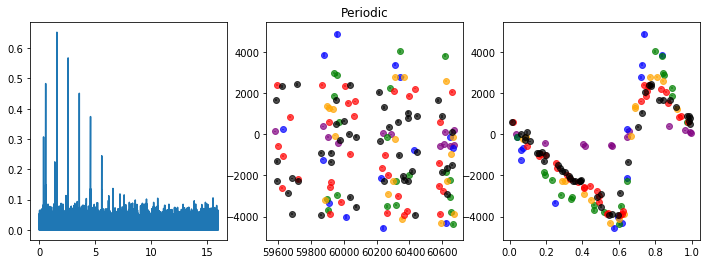

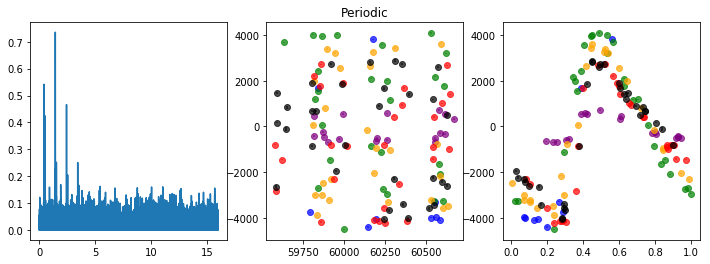

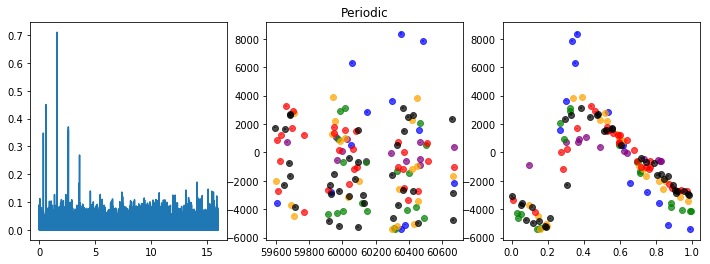

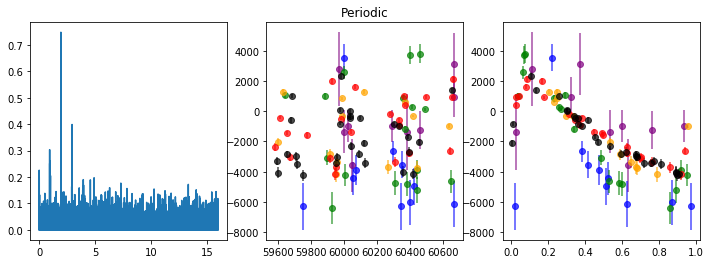

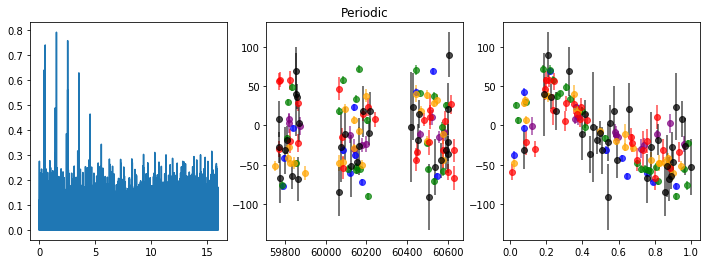

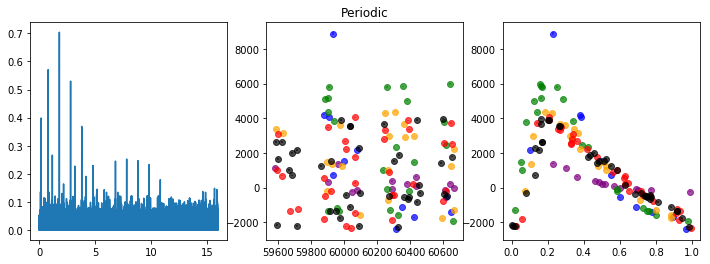

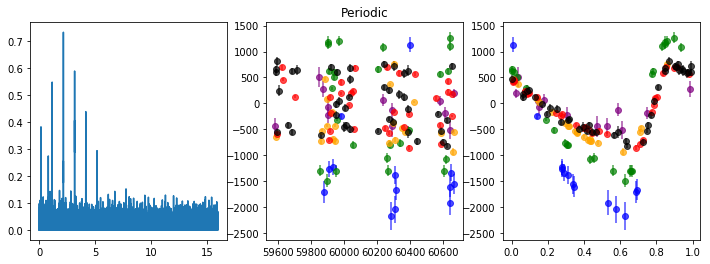

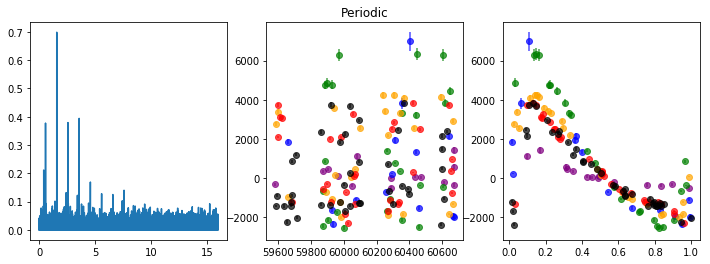

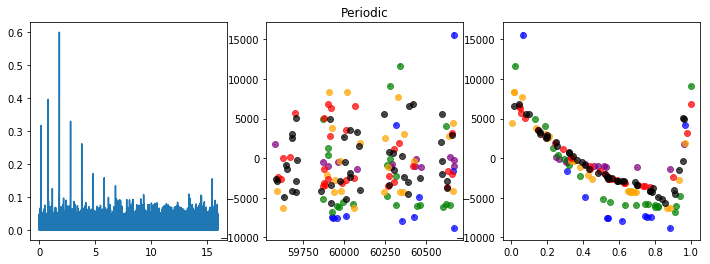

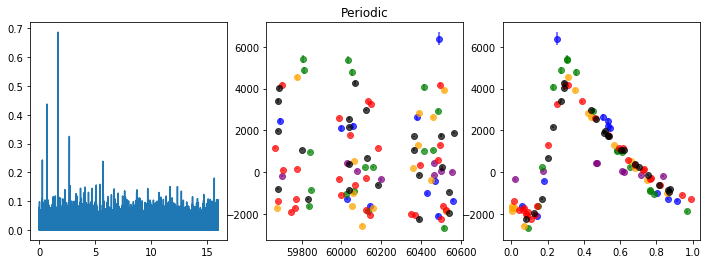

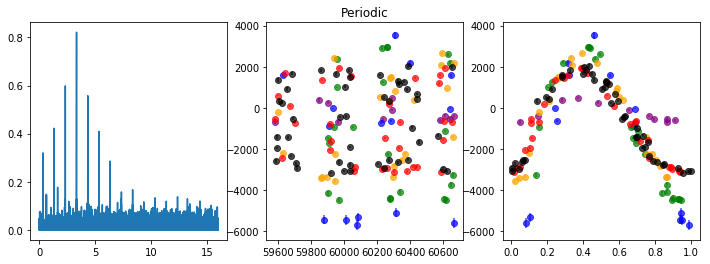

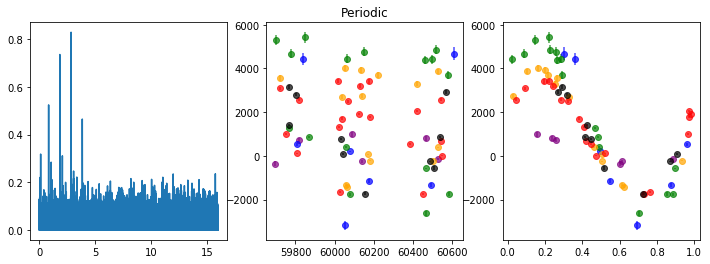

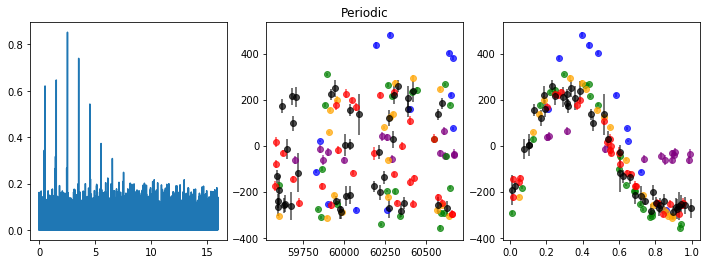

In [19]:
for iobj in train_metadata[(train_metadata['target']==92) & (train_metadata['ddf']==0) ][:25].index:
        plot_period(iobj)

### Metric

In [20]:
def make_undersigmas():
    undersigma_list = np.zeros(len(train_metadata))
    fracunder_list= np.zeros(len(train_metadata))
    for i in train_metadata[(train_metadata['hostgal_photoz']==0)].index:
        #print i
        undersigma=np.zeros(6)
        nbunder=0
        nbdata=0
        for b in range(6):
            base = np.median(flux_list[i][b])
            nmad = np.median(np.abs(flux_list[i][b] - base)) * 1.4826
            undersigma[b] = np.min( (flux_list[i][b]-base)/ np.maximum(err_list[i][b],nmad) )
            nbunder += np.sum( (flux_list[i][b]-base)/ np.maximum(err_list[i][b],nmad)<-3)
            nbdata += len(flux_list[i][b])
        undersigma_list[i] = np.min(undersigma)
        fracunder_list[i] = nbunder*1./(nbdata)
    return undersigma_list, fracunder_list

In [21]:
def make_frequencies():
    lombscargle_frequency = np.zeros(len(train_metadata))
    lombscargle_power = np.zeros(len(train_metadata))
    for iobj in train_metadata[(train_metadata['hostgal_photoz']==0)].index:
        
        time_obj = np.concatenate(times_list[iobj])
        flux_obj = np.concatenate(flux_list[iobj])
        err_obj = np.concatenate(err_list[iobj])

        frequency, power = LombScargle(time_obj, flux_obj,err_obj).autopower(maximum_frequency=16.0)     
        lombscargle_frequency[iobj] = frequency[np.where(power==np.max(power))]
        lombscargle_power[iobj] = power[np.where(power==np.max(power))]
        
    return lombscargle_frequency,lombscargle_power

In [22]:
undersigma,fracunder = make_undersigmas()

In [23]:
ls_frequency,ls_power = make_frequencies()

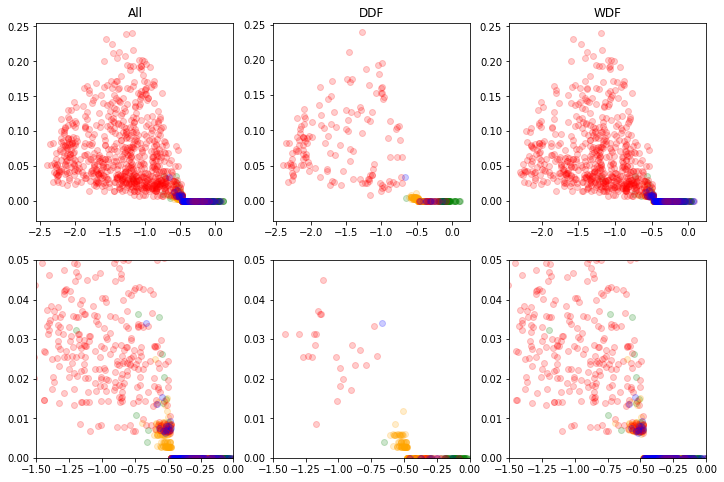

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for t in gal_target:
    ax = axes[0,0]
    ax.scatter(-np.log10(-undersigma[t_type[t]]),fracunder[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,1]
    ax.scatter(-np.log10(-undersigma[ddf_type[t]]),fracunder[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,2]
    ax.scatter(-np.log10(-undersigma[wdf_type[t]]),fracunder[wdf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,0]
    ax.scatter(-np.log10(-undersigma[t_type[t]]),fracunder[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,1]
    ax.scatter(-np.log10(-undersigma[ddf_type[t]]),fracunder[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,2]
    ax.scatter(-np.log10(-undersigma[wdf_type[t]]),fracunder[wdf_type[t]],color=t_colors[t],alpha=0.2)

ax = axes[0,0]
ax.set_title("All")
ax = axes[0,1]
ax.set_title("DDF")
ax = axes[0,2]
ax.set_title("WDF")
for i in range(3):
    ax = axes[1,i]
    ax.set_xlim((-1.5,0))
    ax.set_ylim((0,0.05))

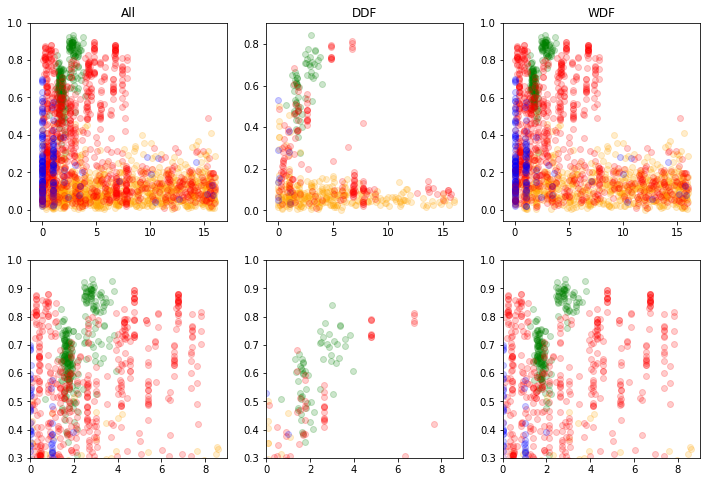

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for t in gal_target:
    ax = axes[0,0]
    ax.scatter(ls_frequency[t_type[t]],ls_power[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,1]
    ax.scatter(ls_frequency[ddf_type[t]],ls_power[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,2]
    ax.scatter(ls_frequency[wdf_type[t]],ls_power[wdf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,0]
    ax.scatter(ls_frequency[t_type[t]],ls_power[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,1]
    ax.scatter(ls_frequency[ddf_type[t]],ls_power[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,2]
    ax.scatter(ls_frequency[wdf_type[t]],ls_power[wdf_type[t]],color=t_colors[t],alpha=0.2)


ax = axes[0,0]
ax.set_title("All")
ax = axes[0,1]
ax.set_title("DDF")
ax = axes[0,2]
ax.set_title("WDF")
for i in range(3):
    ax = axes[1,i]
    ax.set_xlim((0,9))
    ax.set_ylim((0.3,1))

## Type 53 (Long periodic)

In [26]:
def plot_long_period(iobj):
    time_obj = np.concatenate(times_list[iobj][:3])
    flux_obj = np.concatenate(flux_list[iobj][:3])
    err_obj = np.concatenate(err_list[iobj][:3])
    
    frequency, power = LombScargle(time_obj, flux_obj,err_obj).autopower(maximum_frequency=0.01)
    #frequency, power = LombScargle(times_list[iobj][1], flux_list[iobj][1],err_list[iobj][1]).autopower()
    best_frequency=frequency[np.where(power==np.max(power))]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    ax=axes[0]
    ax.plot(frequency, power)
    ax=axes[1]
    plt.sca(ax)
    plot_one_object(object_list[iobj])
    ax.set_title(target_types[train_metadata.loc[iobj,'target']])
    ax=axes[2]
    plt.sca(ax)
    plot_one_object(object_list[iobj],frequency=best_frequency)
    return best_frequency

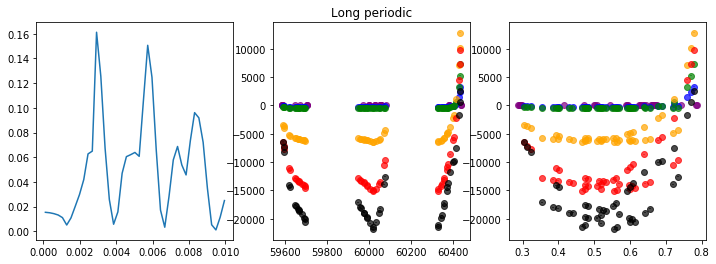

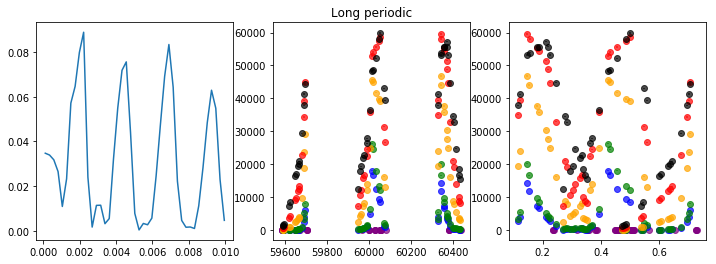

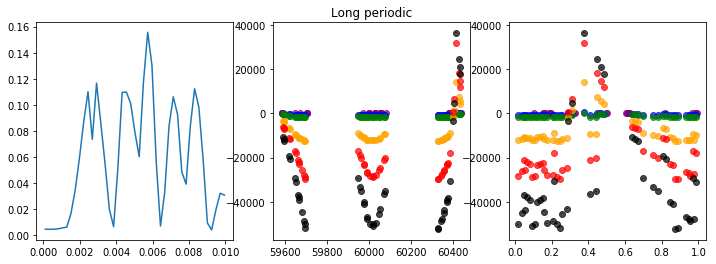

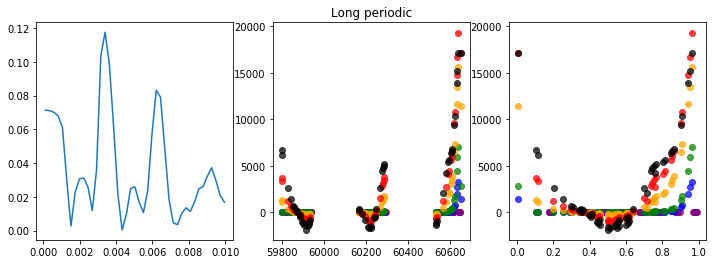

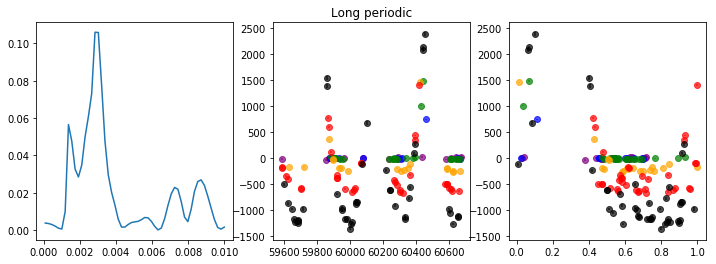

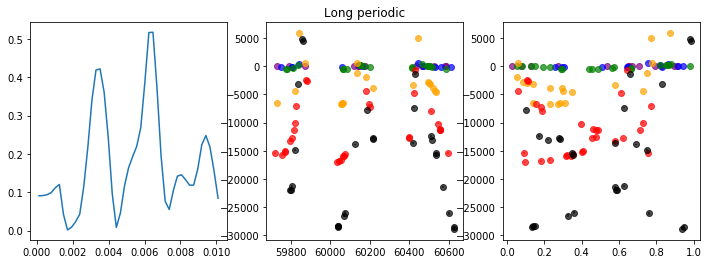

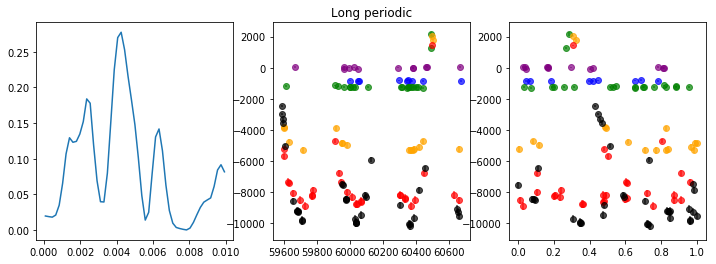

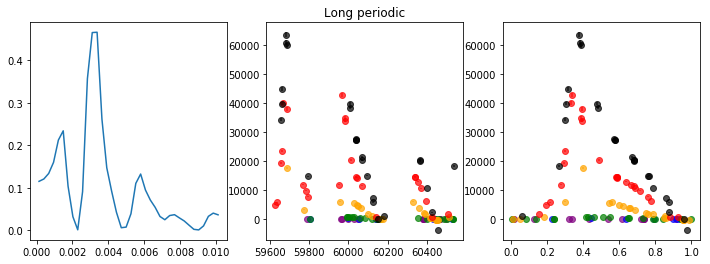

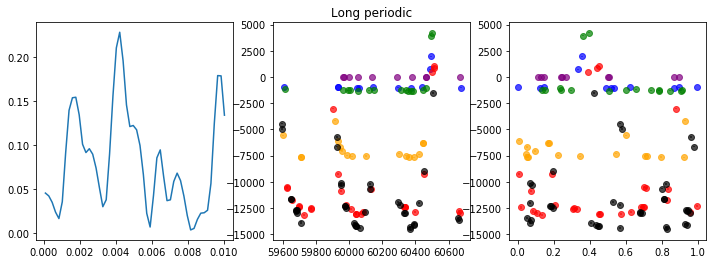

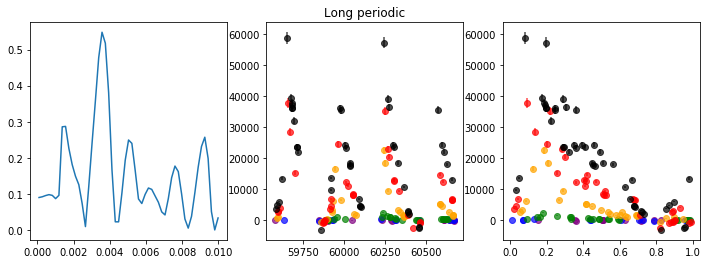

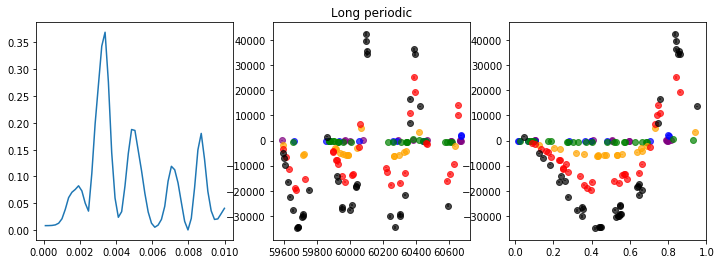

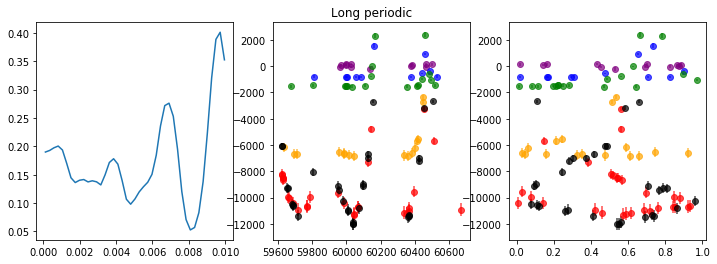

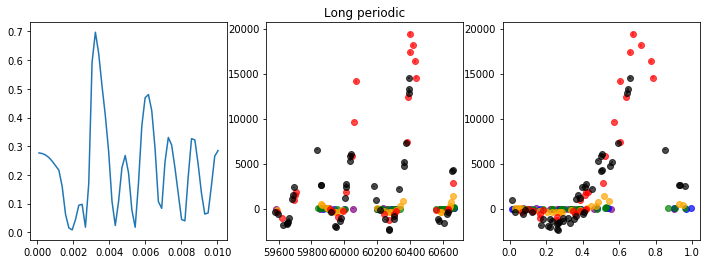

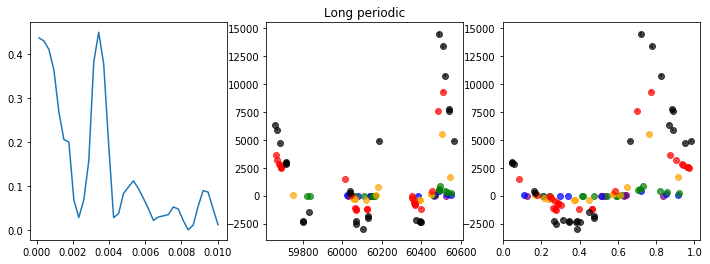

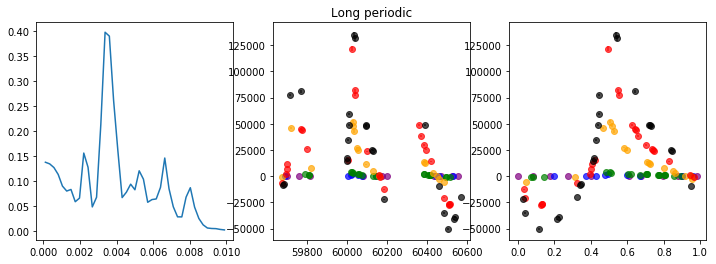

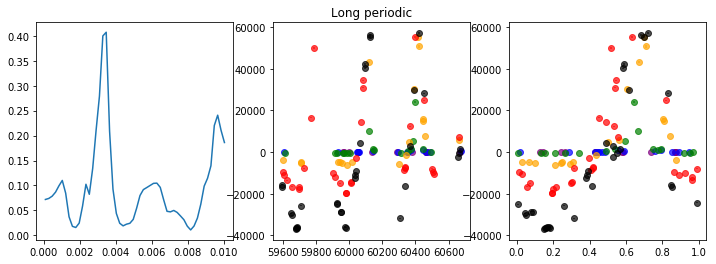

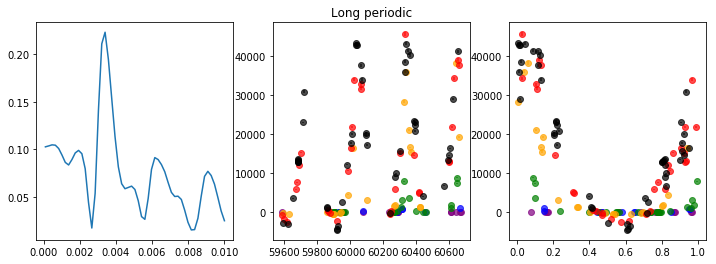

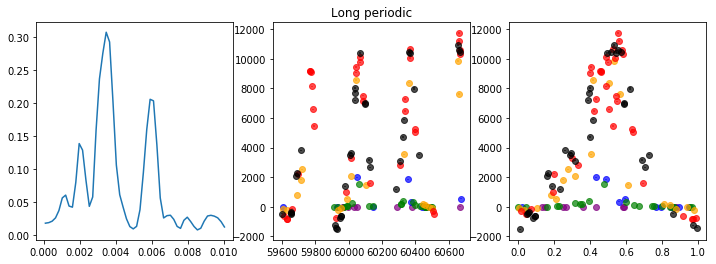

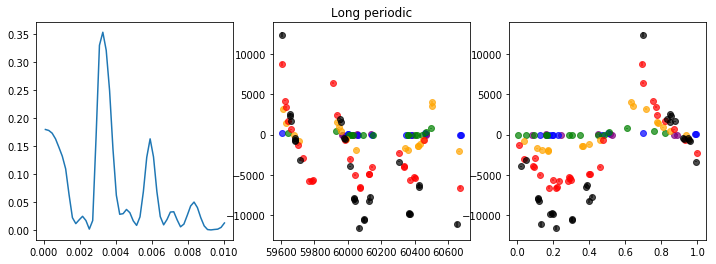

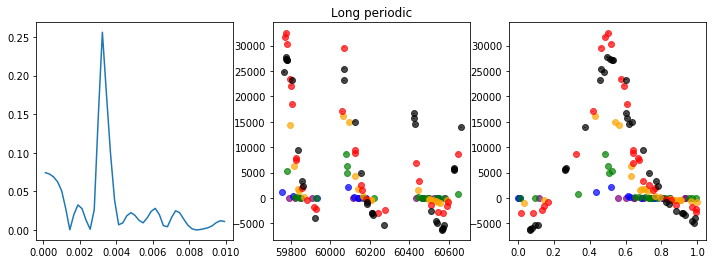

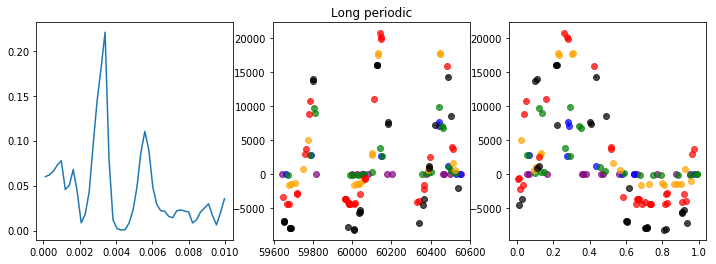

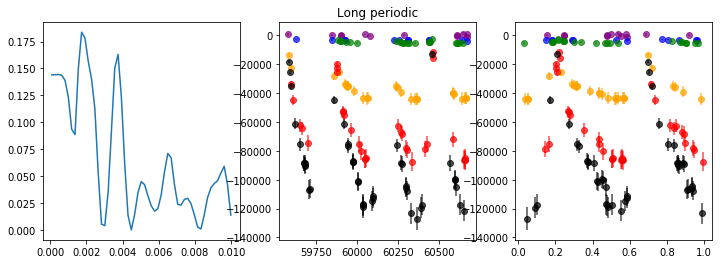

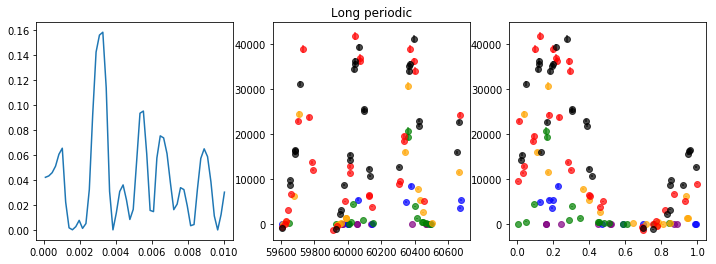

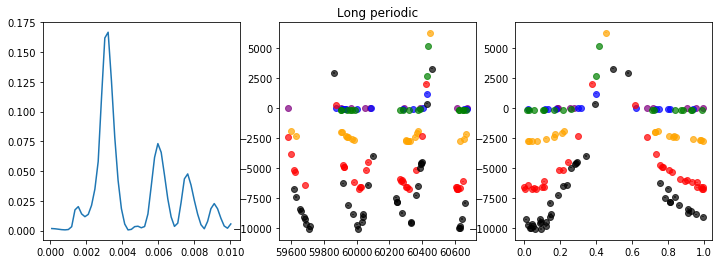

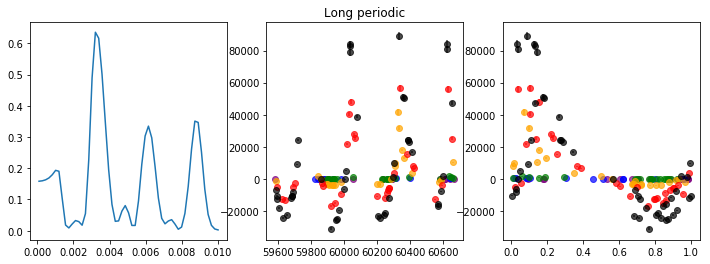

In [27]:
for iobj in train_metadata[(train_metadata['target']==53)].index[:25]:
    best=plot_long_period(iobj)
    #print best

LombScargle fails for very large periods...

In [28]:
def make_stds():
    stds_list = np.zeros((len(train_metadata),6))
    for i in train_metadata[(train_metadata['hostgal_photoz']==0)].index:
        #print i
        for b in range(6):
            stds_list[i][b] = np.std(flux_list[i][b])
    return stds_list

In [29]:
stds = make_stds()

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in divide
  """


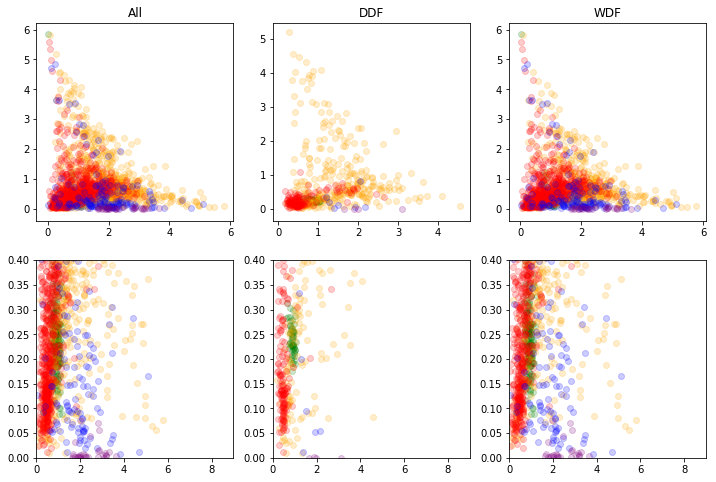

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for t in gal_target:
#for t in [92]:
    plotx=stds[:,5]/np.mean(stds,axis=1)
    ploty=stds[:,0]/np.mean(stds,axis=1)
    ax = axes[0,0]
    ax.scatter(plotx[t_type[t]],ploty[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,1]
    ax.scatter(plotx[ddf_type[t]],ploty[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,2]
    ax.scatter(plotx[wdf_type[t]],ploty[wdf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,0]
    ax.scatter(plotx[t_type[t]],ploty[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,1]
    ax.scatter(plotx[ddf_type[t]],ploty[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,2]
    ax.scatter(plotx[wdf_type[t]],ploty[wdf_type[t]],color=t_colors[t],alpha=0.2)


ax = axes[0,0]
ax.set_title("All")
ax = axes[0,1]
ax.set_title("DDF")
ax = axes[0,2]
ax.set_title("WDF")
for i in range(3):
    ax = axes[1,i]
    ax.set_xlim((0,9))
    ax.set_ylim((0.,0.4))

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in divide
  """


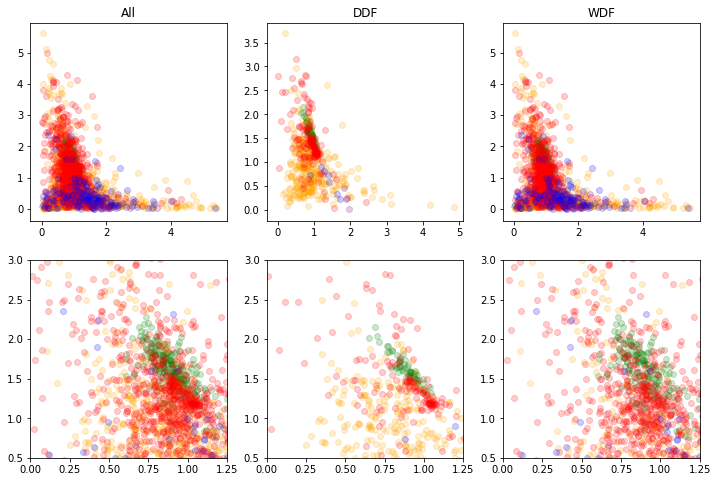

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for t in gal_target:
#for t in [53]:
    plotx=stds[:,4]/np.mean(stds,axis=1)
    ploty=stds[:,1]/np.mean(stds,axis=1)
    ax = axes[0,0]
    ax.scatter(plotx[t_type[t]],ploty[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,1]
    ax.scatter(plotx[ddf_type[t]],ploty[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,2]
    ax.scatter(plotx[wdf_type[t]],ploty[wdf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,0]
    ax.scatter(plotx[t_type[t]],ploty[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,1]
    ax.scatter(plotx[ddf_type[t]],ploty[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,2]
    ax.scatter(plotx[wdf_type[t]],ploty[wdf_type[t]],color=t_colors[t],alpha=0.2)


ax = axes[0,0]
ax.set_title("All")
ax = axes[0,1]
ax.set_title("DDF")
ax = axes[0,2]
ax.set_title("WDF")
for i in range(3):
    ax = axes[1,i]
    ax.set_xlim((0,1.25))
    ax.set_ylim((0.5,3.0))

## Type 6 (Microlensing)

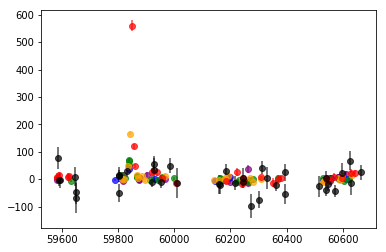

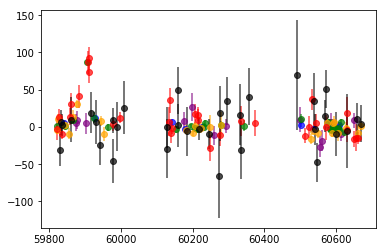

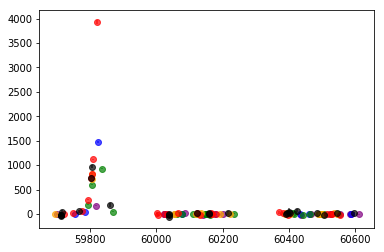

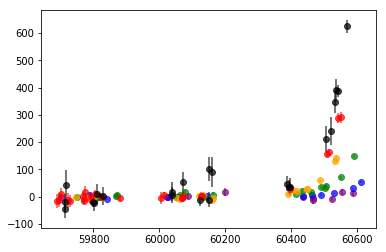

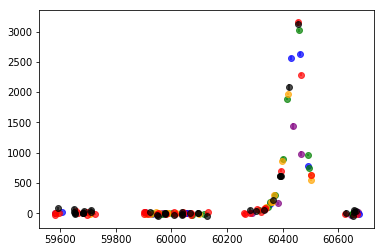

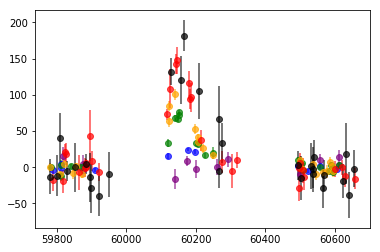

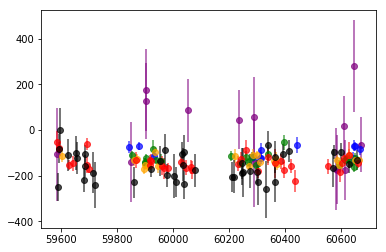

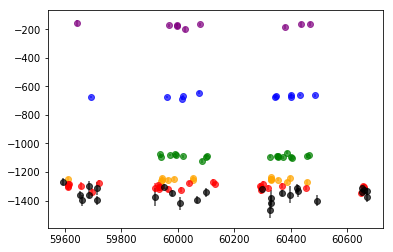

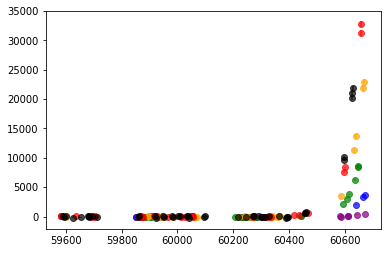

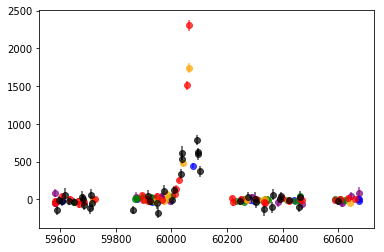

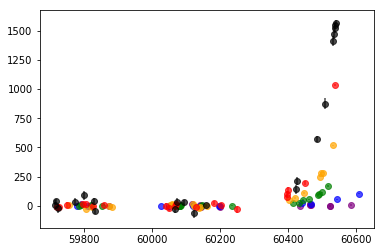

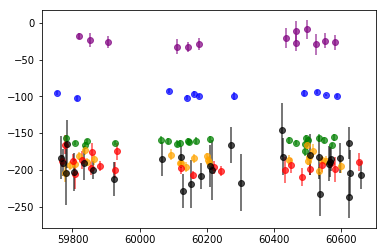

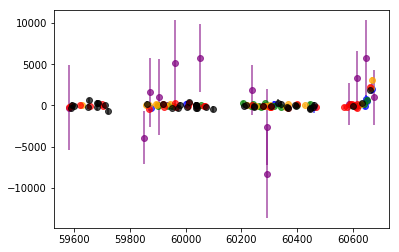

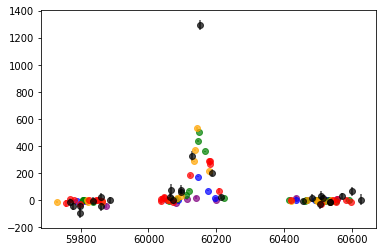

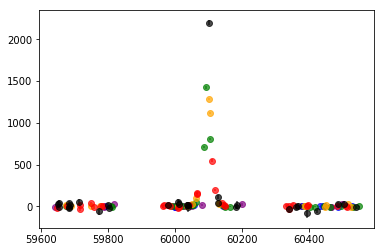

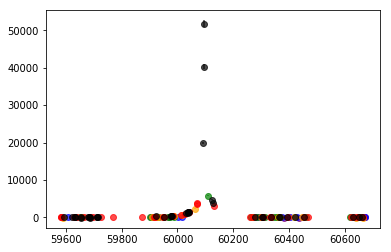

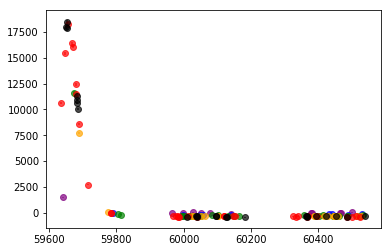

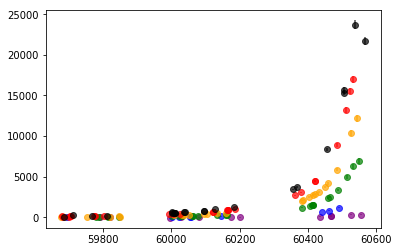

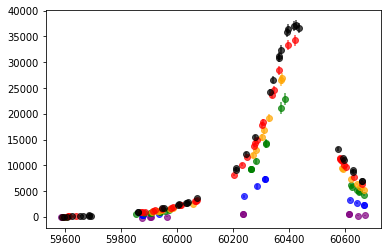

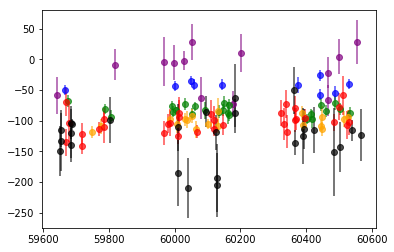

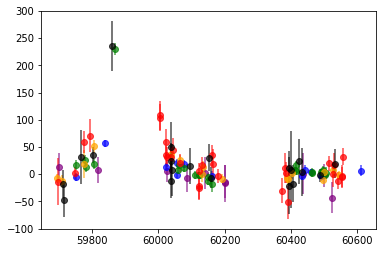

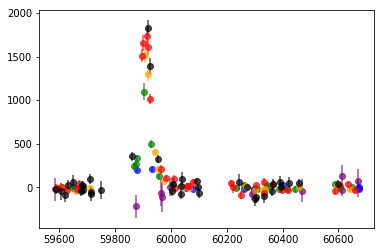

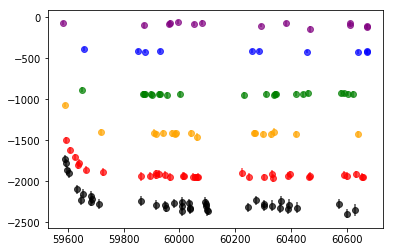

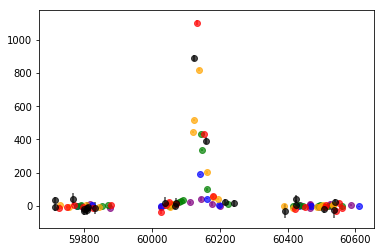

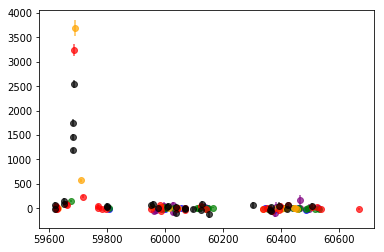

In [32]:
for iobj in train_metadata[(train_metadata['target']==6) & (train_metadata['ddf']==0)]['object_id'][:25]:
    plt.figure()
    plot_one_object(iobj)

In [33]:
# Item 1 : relative median flux !
def make_medians():
    median_list = np.zeros((len(train_metadata),6))
    median_errors = np.zeros((len(train_metadata),6))
    for i in train_metadata[(train_metadata['hostgal_photoz']==0)].index:
        #print i
        for b in range(6):
            median_list[i][b] = np.median(flux_list[i][b])
            median_errors[i][b] = np.median(err_list[i][b])
    return median_list,median_errors

In [34]:
medians,err_median = make_medians()

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in divide
  """


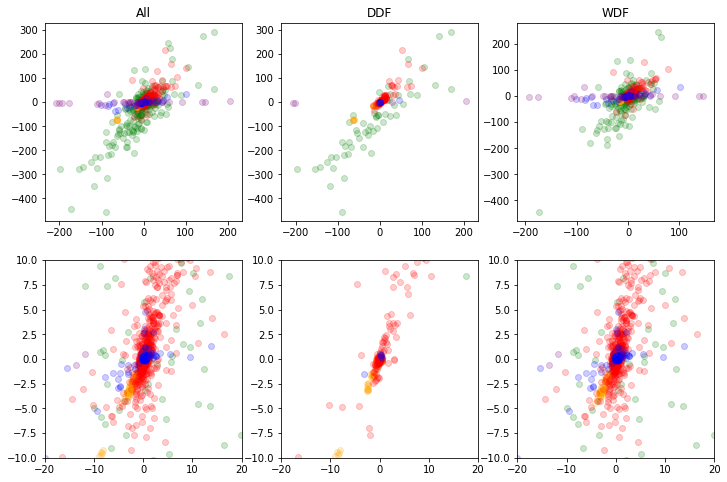

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for t in gal_target:
#for t in [6]:
    plotx=medians[:,4]/err_median[:,4]
    ploty=medians[:,1]/err_median[:,4]
    ax = axes[0,0]
    ax.scatter(plotx[t_type[t]],ploty[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,1]
    ax.scatter(plotx[ddf_type[t]],ploty[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,2]
    ax.scatter(plotx[wdf_type[t]],ploty[wdf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,0]
    ax.scatter(plotx[t_type[t]],ploty[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,1]
    ax.scatter(plotx[ddf_type[t]],ploty[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,2]
    ax.scatter(plotx[wdf_type[t]],ploty[wdf_type[t]],color=t_colors[t],alpha=0.2)


ax = axes[0,0]
ax.set_title("All")
ax = axes[0,1]
ax.set_title("DDF")
ax = axes[0,2]
ax.set_title("WDF")
for i in range(3):
    ax = axes[1,i]
    ax.set_xlim((-20,20))
    ax.set_ylim((-10,10))

### DErive a template... from Microlensing theoretical curve

In [36]:
def microamp(t,(t0,te,umin)):
    u = np.sqrt( umin**2 + ((t-t0)/te)**2 )
    amp = (u**2 + 2) / (u * np.sqrt(u**2+4))
    return amp

In [37]:
# reparametrize the equation to better align the pesudo-degeneracies
# the maximum will be at 1, and the baseline at 0
def microshape(t,(t0,te,wings)):
    tvec=((t-t0)/te)**2
    flux0 = 1.0 / ((1+wings**2) / (np.sqrt(1 + 2*wings**2)) -1)
    return flux0*((1 + tvec + wings**2) / np.sqrt((1+tvec)*(1+tvec+2*wings**2))-1)

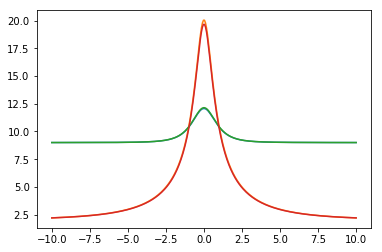

In [38]:
plt.plot(np.linspace(-10,10,300),9*microamp(np.linspace(-10,10,300),(0.0,1.0,1.)))
plt.plot(np.linspace(-10,10,300),2*microamp(np.linspace(-10,10,300),(0.0,6.0,0.1)))

plt.plot(np.linspace(-10,10,300),microshape(np.linspace(-10,10,300),(0.0,1.0,np.sqrt(2.)))*0.35*9+9)
plt.plot(np.linspace(-10,10,300),microshape(np.linspace(-10,10,300),(0.0,0.6,np.sqrt(200)))*17.7+2)



Fitting the template on the data...

In [39]:
#def fit_base_amp(time,flux,err,t0,te,wings):

def fit_microlens(time,flux,err,paraminit=False):
    wmat=np.zeros((2,2))
    yvec=np.zeros(2)
    baseamp = np.zeros((6,2))
    
    def _chi2_microlens((t0,te,wings)):
        chi2 = 0
        for b in range(6):
            shape = microshape(time[b],(t0,te,wings)) 
            # now, predict value of base and amp.
            wmat[0][0] = np.sum(shape**2/err[b]**2)
            wmat[0][1] = wmat[1][0] = np.sum(shape/err[b]**2)
            wmat[1][1] = np.sum(1./err[b]**2)
            yvec[0] = np.sum(flux[b]*shape/err[b]**2)
            yvec[1] = np.sum(flux[b]/err[b]**2)
            try:
                baseamp[b] = np.linalg.inv(wmat).dot(yvec)
                baseamp[b][0] = np.max((baseamp[b][0],0))
            except:
                baseamp[b][0]=0
                baseamp[b][1]=np.sum(flux[b]/err[b]**2)/np.sum(1./err[b])
            
            chi2 += np.sum(( baseamp[b][0] * shape + baseamp[b][1] - flux[b] ) **2 / err[b]**2)
        
        return chi2
    
    if not paraminit:
        t0 = np.concatenate(time)[np.where(np.concatenate(flux)/np.concatenate(err)==np.max(np.concatenate(flux)/np.concatenate(err)))]
        te = 100.
        wings = 1.0
    else:
        (t0,te,wings) = paraminit
    
    #_chi2_microlens((t0,te,wings))
    #return (baseamp, (t0,te,wings))
    
    params=optimize.fmin(_chi2_microlens,(t0,te,wings),full_output=1,disp=0)
    return (baseamp,params[0], params[1],np.sum([len(f) for f in flux]))
    #return optimize.fmin(_chi2_microlens,(base,amp0,t0,te,wings))

def plot_microlens(time,flux,err,params):
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
    #plt.title(target_types[train_metadata.loc[iobj,'target']]) 
    for band in range(6):
        ax = axes[band // 3, band % 3]
        ax.errorbar(time[band],flux[band],yerr=err[band],fmt='o',color=colors[band])
        time_grid=(np.arange(59550,60705,5.))
        ymicro=microshape(time_grid,params[1])*params[0][band][0] + params[0][band][1]
        ax.plot(time_grid,ymicro,color=colors[band])

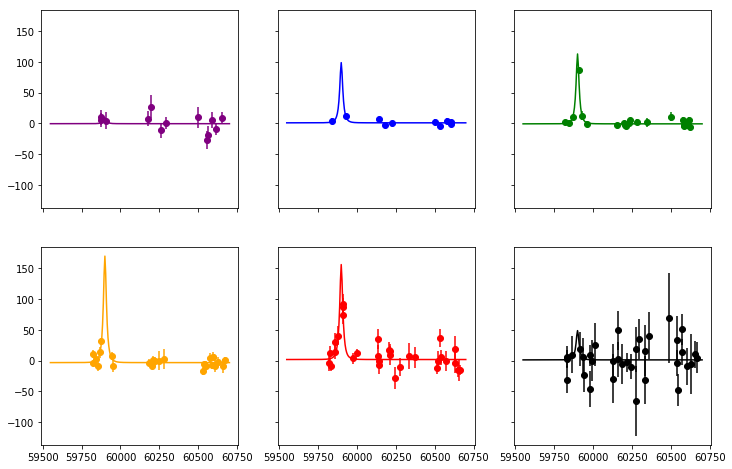

In [40]:
iobj=train_metadata[(train_metadata['target']==6) & (train_metadata['ddf']==0)].index[1]

params = fit_microlens(times_list[iobj],flux_list[iobj],err_list[iobj]) 
plot_microlens(times_list[iobj],flux_list[iobj],err_list[iobj],params[:2])


This is a fit : computation takes some time...

In [41]:
def make_microparams():
    microparams_list=[0]*len(train_metadata)
    
    for iobj in train_metadata[(train_metadata['hostgal_photoz']==0)].index:
        if iobj%100==0: print iobj
        microparams_list[iobj] = fit_microlens(times_list[iobj],flux_list[iobj],err_list[iobj])

    return microparams_list

In [42]:
microparams = make_microparams()

0


/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


700
1100
1300
1500
1700
2000
2700
3200
3300
3400
3800
4200
5000
5200
6000
6500
6800
7300
7400
7500
7700


In [43]:
microamp = np.zeros((len(train_metadata),6))
microbase = np.zeros((len(train_metadata),6))
microt0 = np.zeros(len(train_metadata))
microte = np.zeros(len(train_metadata))
microwings = np.zeros(len(train_metadata))
microchi2 = np.zeros(len(train_metadata))
microndf = np.zeros(len(train_metadata))
for iobj in train_metadata[(train_metadata['hostgal_photoz']==0)].index:
    microamp[iobj] = microparams[iobj][0][:,0]
    microbase[iobj] = microparams[iobj][0][:,1]
    microt0[iobj] = np.abs(microparams[iobj][1][0])
    microte[iobj] = np.abs(microparams[iobj][1][1])
    microwings[iobj] = microparams[iobj][1][2]
    microchi2[iobj] = microparams[iobj][2]
    microndf[iobj] = microparams[iobj][3]-15

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


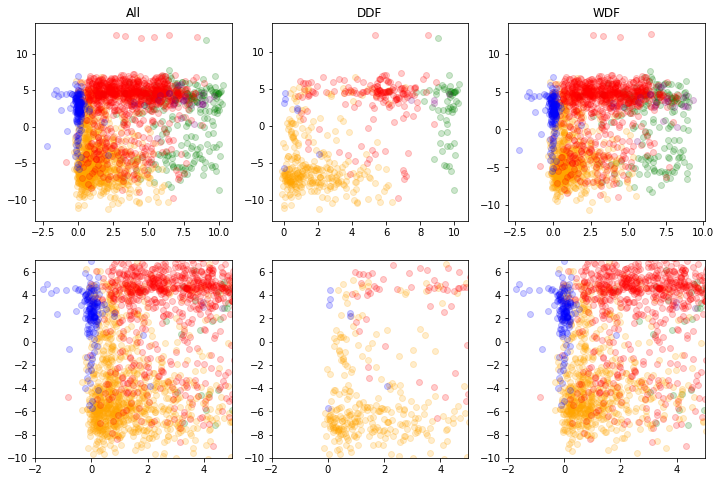

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for t in gal_target:
#for t in [6]:
    plotx=np.log(microchi2 / microndf)
    ploty=np.log(microte)
    ax = axes[0,0]
    ax.scatter(plotx[t_type[t]],ploty[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,1]
    ax.scatter(plotx[ddf_type[t]],ploty[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,2]
    ax.scatter(plotx[wdf_type[t]],ploty[wdf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,0]
    ax.scatter(plotx[t_type[t]],ploty[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,1]
    ax.scatter(plotx[ddf_type[t]],ploty[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,2]
    ax.scatter(plotx[wdf_type[t]],ploty[wdf_type[t]],color=t_colors[t],alpha=0.2)


ax = axes[0,0]
ax.set_title("All")
ax = axes[0,1]
ax.set_title("DDF")
ax = axes[0,2]
ax.set_title("WDF")
for i in range(3):
    ax = axes[1,i]
    ax.set_xlim((-2,5))
    ax.set_ylim((-10,7))

# Writing output to cvs file

Metrics are for now
- maxsigma, frac3sigma, undersigma, fracunder, ls_frequency,ls_power, microt0, microte, microwings, microchi2, microndf

And per band:
- stds, medians,err_median, microbase, microamp 

In [45]:
train_metadata['maxsigma'] = maxsigma
train_metadata['fracmaxsigma'] = frac3sigma
train_metadata['undersigma'] = undersigma
train_metadata['fracunder'] = fracunder
train_metadata['ls_frequency'] = ls_frequency
train_metadata['ls_power'] = ls_power
train_metadata['micro_t0'] = microt0
train_metadata['micro_te'] = microte
train_metadata['micro_wings'] = microwings
train_metadata['micro_chi2'] = microchi2
train_metadata['n_datapoints'] = microndf+15




In [46]:
train_metadata['stds']=train_metadata.apply(lambda x : stds[x.name],axis=1)
train_metadata['median']=train_metadata.apply(lambda x : medians[x.name],axis=1)
train_metadata['median_err']=train_metadata.apply(lambda x : err_median[x.name],axis=1)
train_metadata['microbase']=train_metadata.apply(lambda x : microbase[x.name],axis=1)
train_metadata['microamp']=train_metadata.apply(lambda x : microamp[x.name],axis=1)

In [47]:
train_metadata.to_csv('training_set_metadata_enriched.csv')